# Лабораторная работа #2 по курсу "Методы оптимизации"
### Выполнил: Косенков Александр - студент группы РК6-64Б

## Задание:
Реализовать и исследовать математическую модель Вольтерра - Лотки для имитации межвидового взаимодействия. Сформулировать
критерий "устойчивости" биологической системы на основе численности особей на произвольно заданном интервале моделирования.
Отыскать экстремум предложенного критерия как функции 4-х параметров модели.

**Импорт всех необходимых библиотек:**

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pathlib
import lab2

**Определение конфигурационных переменных**

In [42]:
ROOT_DIR = str(pathlib.Path().absolute())
PLOTS_DPI = 300

T_MAX = 15

### Предварительный анализ:
Иодель Лотки-Вольтерры является первоначальной и простейшей системой (без учета миграции особей и пр.) для описания
модели взаимодействия «хищник-жертва», т.е. популяции хищников и популяции жертв, взаимодействующих в какой-то среде:
жертвы едят растительность, хищники — жертв.\
Данную модель можно прдставить в виде системы из двух уравнений:\
$$
\begin{cases} \dot{x} = (\alpha - \beta y)x \\ \dot{y} = (-\gamma + \delta x)y \end{cases} 
$$
где: 
- x — численность жертв (травоядных);
- y — численность хищников;
- $\alpha$ — вероятность того, что травоядные размножатся (переменная `a` в дальнейшем);
- $\beta$ — вероятность того, что травоядное будет съедено хищником (переменная `b` в дальнейшем); 
- $\gamma$ — вероятность того, что хищник умрет от голода (переменная `g` в дальнейшем);
- $\delta$ — вероятность того, что хищнику хватит еды на дальнейшее размножение (переменная `d` в дальнейшем).


Модель Лотки-Вольтерры является первоначальной и простейшей системой (без учета миграции особей и пр.) для описания
модели взаимодействия «хищник-жертва», т.е. популяции хищников и популяции жертв, взаимодействующих в какой-то среде:
жертвы едят растительность, хищники — жертв.\
Данную модель можно прдставить в виде системы из двух уравнений:\

Перед постановкой задачи поиска устойчивости системы следует проанализировать решения системы в общем случае, при произвольно
заданных параметрах. Например, `a = 2`, `b = 5`, `g = 2`, `d = 2`.\
Далее, используя функционал класса `Biome`, описанный в модуле `lab2.py` были получены результаты решения системы. Данный класс
предоставляет возможность инициализации системы параметрами `a`, `b`, `g`, `d` и начальными значениями популяции
хищников и жертв; возможность решения системы для определенного интервала времени `[0, tmax]`:\
`# Lotka-Volterra equations
for i in range(self.__n_iters - 1):
    self.prey[i + 1] = self.prey[i] + self.__dt * self.prey[i] * (alpha - self.pred[i] * beta)
    self.pred[i + 1] = self.pred[i] + self.__dt * self.pred[i] * (delta * self.prey[i] - gamma)`;\
а также возможность отображения графиков зависимости популяции жертв и хищников от времени и фазовой траектори системы
Лотки-Вольтеры для заданных ранее параметров.

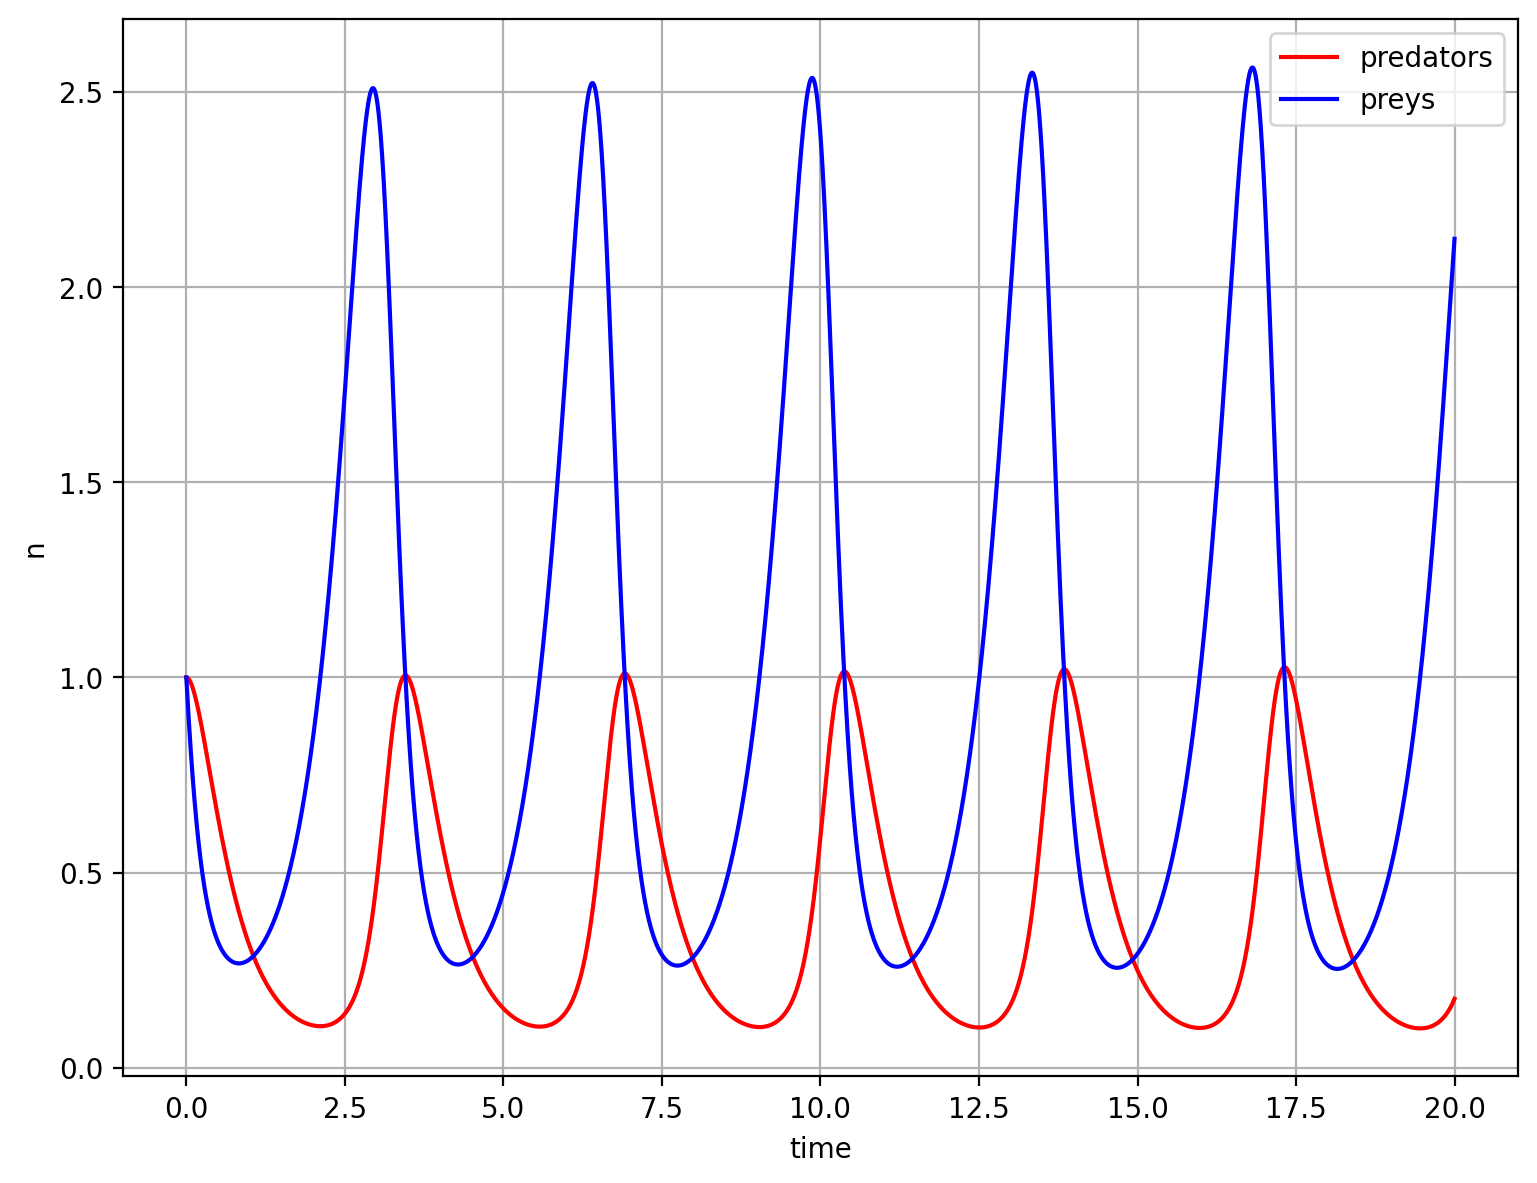

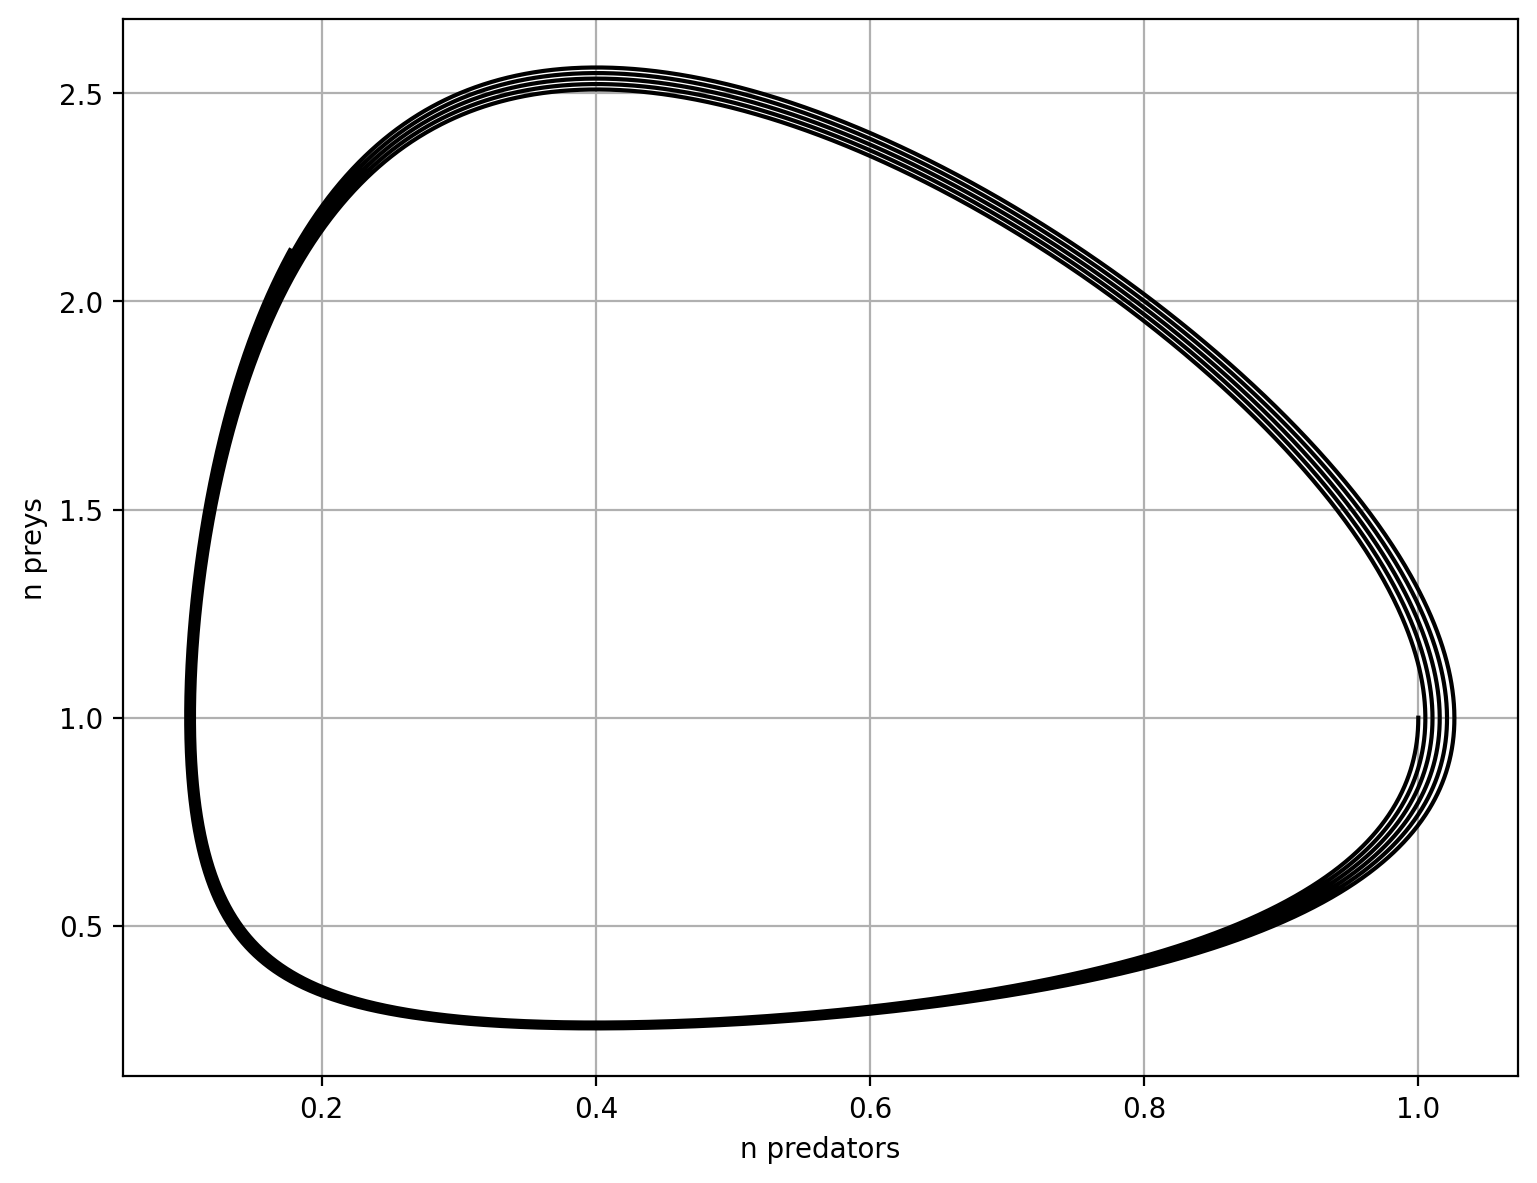

In [43]:
a = 2
b = 5
g = 2
d = 2 
biome = lab2.Biome(tmax=20)
biome.run(a, b, g, d)
biome.plot()
biome.plot_cycle()

Из графика для фазовой траектории выше можно заметить, что с течением времени хищников становится больше, чем жертв,
что в долгосрочной перспективе может привести к вымиранию жертв в следствие неравномерного роста популяции особей хищников и
жертв.\
Из этого вывода возникает задача введения критерия устойчивости системы, которая обеспечит долгосрочную сбалансированность
во взаимодействии между двумя видами. В качестве сбалансированности можно рассматривать разность между хищниками и жертвами.
В таком случае задачей сводится к минимизации этой суммы, но так как зависимости числа популяции обоих видов периодичны и
сдвинуты друг от друга по фазе (следствие того, что система моделирует поведение - при увеличении одной переменной - уменьшается
другая и наоборот), имеет смысл минимизировать среднее значений разности:\
$$
\sum_{i=1}^{n}{ \mid {x_{i} - y_{i}} } \mid \rightarrow min
$$  
что было реализовано в алгоритме функции `sustainability_crit`:

In [44]:
def sustainability_crit(args):
    biome = lab2.Biome(tmax=T_MAX)
    _, preys, predators = biome.run(*args)
    deviations = 0.
    for i in range(len(preys)):
        deviations += abs(preys[i] - predators[i])
    return deviations / len(preys)

Минимизация значения разности была реализована с помощью функции `minimize` из прикладной библиотеки `scipy`:

In [ ]:
optimize = minimize(sustainability_crit, (a, b, g, d), method='BFGS')
print("Optimized coefficients: a = {}, b = {}, g = {}, d = {}".format(*optimize.x))
biome = lab2.Biome(tmax=T_MAX)
biome.run(*optimize.x)
biome.plot()
biome.plot_cycle()

Анализируя графики, можно сказать, что с найденными оптимальными коэффициентами система стала более уравновешенной,
так как взаимодействие и рост популяции видов происходит более равномерно.

При этом, по найденным параметрам системы можно опредеить стационарную точку системы. Данная точка будет
являтся точкой равновесия системы, относительно которой совершаются колебания. (На графике функции фазовой
траектории данная точка представляет собой центр или фокус - относительно которого траектория совершает вращение.\
Стационарную точку можно получить, приравнивая `x` и `y` к 0:
$$
\binom{{\delta} \over {\gamma}}{{\alpha} \over {\beta}}
$$
Стационарной точкой также является и точка $\binom{0}{0}$, но она не представаляет интереса, так как в таком случае
изначальная популяция обоих видов = 0, а значит особи далее не появляютсяи колебания системы отсутствуют.

In [ ]:
print("delta/gamma = {}\nalpha/beta = {}".format(optimize.x[3] / optimize.x[2], optimize.x[0] / optimize.x[1]))